# Machine Learning Lab 2

## Assignment 3 (Deadline : 05/02/2023 11:59PM)

Total Points : 25

Your answers must be entered in LMS by midnight of the day it is due. 

If the question requires a textual response, you can create a PDF and upload that. 

The PDF might be generated from MS-WORD, LATEX, the image of a hand- written response, or using any other mechanism. 

Code must be uploaded and may require demonstration to the TA. 

Numbers in the parentheses indicate points allocated to the question. 

**Naming Convention**: FirstName_LastName_Lab3_TLP23.ipynb

**Assignment**: 3-class Sentiment Analysis with LSTM on Twitter Data
 

**Objective**:
The objective of this assignment is to train a LSTM neural network to perform 3-class sentiment analysis on Twitter data.
 

**Dataset**:
The dataset used in this assignment is the Sentiment140 dataset, which can be downloaded from http://help.sentiment140.com/for-students. The dataset consists of 1.6 million tweets, labeled as positive (4), neutral (2), or negative (0)


*   Collect a sample of at least 100,000 tweets from the dataset **(1 points)**


*   Preprocess the text data by removing punctuation, lowercasing, removing stop words, and tokenizing the words **(3 points)**

*   Split the data into training and testing sets, and pad the sequences to the same length **(2 points)**

*   Build a LSTM model to classify the tweets as positive, neutral, or negative. The model should have an Embedding layer, followed LSTM layers of your choosing, and a dense layer for output **(7 points)**

*   Train the model on the training data and evaluate its performance on the testing data **(3 points)**


*   Fine-tune the model by experimenting with different architectures, optimizers, activation functions, and hyperparameters. Feel free to experiment with GRUs **(4 points)**


*   Report the accuracy, precision, recall, and F1 score of the model on the testing data. Inclue graphs and necessary data. Include this in a markdown cell within the notebook. Compare the basic LSTM model against SOTA and other architectures which you can directly import **(3 points)**


*   Use the trained model to predict the sentiment of 25 new tweets with positive (2), neutral (1), or negative (0) **(2 points)**



# Libraries

In [97]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import nltk
import re
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('wordnet')

import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Downloading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.DataFrame()
for i in range(1,14,1):
  if i<3:
    x = pd.read_csv(f'/content/drive/MyDrive/Padhai_DL_Course/Data/ML2Lab2_LSTM/{i}.tsv',sep='\t', encoding = "ISO-8859-1", names=['ID','t_id','target','tweet'])
    x.drop(['t_id','ID'],axis=1,inplace=True)
  else: 
    x = pd.read_csv(f'/content/drive/MyDrive/Padhai_DL_Course/Data/ML2Lab2_LSTM/{i}.txt',sep='\t', encoding = "ISO-8859-1", names=['ID','target','tweet','O'])
    x.drop(['ID','O'],axis=1,inplace=True)
  train_df = pd.concat([train_df,x],axis=0)

In [4]:
col_names = ["target", "ids", "date", "flag", "user", "tweet"]
test_df = pd.read_csv("/content/drive/MyDrive/Padhai_DL_Course/Data/Test_Data/testdata.manual.2009.06.14 - testdata.manual.2009.06.14.csv", encoding = "ISO-8859-1", names=col_names)

In [5]:
test_df = test_df.drop(['ids', 'date', 'flag','user'], axis = 1)

# Data pre-processing

In [6]:
# no null values available
train_df.isna().sum()

target    0
tweet     0
dtype: int64

In [7]:
# changing the labels
test_df['target'] = test_df['target'].map({2:1, 4:2, 0:0})
train_df['target'] = train_df['target'].map({'negative' : 0, 'neutral' : 1, 'positive': 2})

In [8]:
train_df.reset_index(inplace=True, drop=True)

In [9]:
train_df.groupby(["target"]).count()

,tweet
target,
0,8507
1,24143
2,20718


## we see there is class imbalance

In [10]:
def remove_links_mentions(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

In [11]:
train_df["C_tweet"] = train_df["tweet"].apply(lambda x: remove_links_mentions(x))
test_df["C_tweet"] = test_df["tweet"].apply(lambda x: remove_links_mentions(x))

In [12]:
def basic_clean(bclean_data):
    bclean_data = bclean_data[bclean_data.iloc[:,0] != 'na'] 
    bclean_data = bclean_data[bclean_data.iloc[:,1] != 'na'] # Line 5 and 6 subsets the data from null values.
    col_name = bclean_data.columns[1]
    bclean_data = bclean_data.drop_duplicates(subset=[col_name], keep='first') # Removing duplcates based on the column ID 1
    bclean_data = data_clean(bclean_data) # Calls the data_clean function
    return bclean_data

    
# functions that will perform lemmatization and stemming
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])

def stem_text(text):
    return " ".join([stemmer.stem(w) for w in word_tokenize(text)])


# function that will clean the data
def data_clean(clean_data):
    # clean_data["C_tweet"] = clean_data["tweet"].apply(lambda x: str(x).lower()) # Converts the text to lower
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x)) # removes special characters
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: ''.join([i for i in x if not i.isdigit()])) # removes digits
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: ' '.join(x.split())) # Removes unwanted whitespaces in between
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: word_tokenize(x)) # Tokenization is where the texts are converted to list
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: [y for y in x if y not in stop_words]) # from the converted list the stopwords are removed
    clean_data["C_tweet"] = clean_data["C_tweet"].apply(lambda x: " ".join(x)) 
    # clean_data["Lem_tweet"] = clean_data["C_tweet"].apply(lambda x: lemmatize_text(x)) # function that lemmatizes the text 
    # clean_data["Stem_tweet"] = clean_data["C_tweet"].apply(lambda x: stem_text(x)) # function that stems the text 
    return clean_data

In [13]:
clean_train_df = data_clean(train_df)

In [14]:
clean_train_df.drop(columns=['tweet'], inplace=True)

In [15]:
clean_test_df = data_clean(test_df)
clean_test_df.drop(columns=['tweet'], inplace=True)

In [16]:
# duplicating samples among the classes in the dataset to balance out for the imbalance
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(clean_train_df[['C_tweet', 'target']], clean_train_df.target)

In [17]:
X_resampled_df = pd.DataFrame(X_resampled, columns=clean_train_df.columns)

In [18]:
X_train, X_val = train_test_split(X_resampled_df, test_size=0.2, random_state=1, stratify=X_resampled_df["target"])

# Train Test Case

In [19]:
train_set1 = list(X_train.to_records(index = False))
val_set1 = list(X_val.to_records(index = False))
test_set1 = list(clean_test_df.to_records(index = False))

# train_set2 = list(train_df[["target", "Lem_tweet"]].to_records(index = False))
# test_set2 = list(test_df[["target", "Lem_tweet"]].to_records(index = False))

# train_set3 = list(train_df[["target", "Stem_tweet"]].to_records(index = False))
# test_set3 = list(test_df[["target", "Stem_tweet"]].to_records(index = False))

# Tokenization

In [20]:
train_set_tok_1 = [(label, word_tokenize(tweet)) for label, tweet in train_set1]
val_set_tok_1 = [(label, word_tokenize(tweet)) for label, tweet in val_set1]
test_set_tok_1 = [(label, word_tokenize(tweet)) for label, tweet in test_set1]

# train_set_tok_2 = [(label, word_tokenize(tweet)) for label, tweet in train_set2]
# test_set_tok_2 = [(label, word_tokenize(tweet)) for label, tweet in test_set2]

# train_set_tok_3 = [(label, word_tokenize(tweet)) for label, tweet in train_set3]
# test_set_tok_3 = [(label, word_tokenize(tweet)) for label, tweet in test_set3]

In [21]:
def create_vocab(train_set, val_set, test_set):
  index2word = ["<PAD>", "<SOS>", "<EOS>"]
  
  for ds in [train_set, val_set, test_set]:
    for label, tweet in ds:
      for token in tweet:
        if token not in index2word:
          index2word.append(token)
  return index2word

In [22]:
index2word1 = create_vocab(train_set_tok_1, val_set_tok_1, test_set_tok_1)
# index2word2 = create_vocab(train_set_tok_2, test_set_tok_2)
# index2word3 = create_vocab(train_set_tok_3, test_set_tok_3)

In [23]:
# prnting the maximum lenght squence from the
print(f'Maximum sequence in train {max(train_df["C_tweet"].str.split().apply(lambda x:len(x)))}')
# print(f'Maximum sequence in train {max(val_set["C_tweet"].str.split().apply(lambda x:len(x)))}')
print(f'Maximum sequence in test {max(test_df["C_tweet"].str.split().apply(lambda x:len(x)))}')

Maximum sequence in train 573
Maximum sequence in test 21


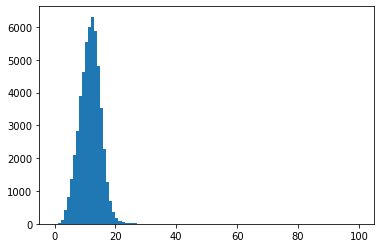

In [24]:
plt.hist(train_df["C_tweet"].str.split().apply(lambda x:len(x)).tolist(), 100, range=[0, 100]);

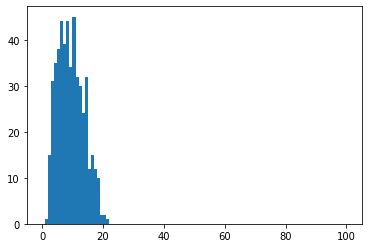

In [25]:
plt.hist(test_df["C_tweet"].str.split().apply(lambda x:len(x)).tolist(), 100, range=[0, 100]);

## Although we see that the max length of the sequences in train case is higher, and in the distribution we see most of it are in the range of (1, 40). So we will have to truncate the sequence to a number that would have capture most of the data

In [26]:
seq_length = 32

In [27]:
def encode_and_pad(tweet, length):
    sos = [index2word["<SOS>"]]
    eos = [index2word["<EOS>"]]
    pad = [index2word["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [index2word[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # tweet is longer than possible; truncating
        encoded = [index2word[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [28]:
index2word = {word : i  for i, word in enumerate(index2word1)}

In [29]:
train_encoded = [(encode_and_pad(tweet[1], seq_length), tweet[0]) for tweet in train_set_tok_1]
val_encoded = [(encode_and_pad(tweet[1], seq_length), tweet[0]) for tweet in val_set_tok_1]
test_encoded = [(encode_and_pad(tweet[1], seq_length), tweet[0]) for tweet in test_set_tok_1]

In [30]:
train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])

val_x = np.array([tweet for tweet, label in val_encoded])
val_y = np.array([label for tweet, label in val_encoded])

test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

In [31]:
train_ids = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_ids = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_ids = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

In [32]:
batch_size = 8
train_dl = DataLoader(train_ids, shuffle=True, batch_size=batch_size, drop_last=True)
valid_dl = DataLoader(val_ids, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ids, shuffle=True, batch_size=batch_size, drop_last=True)

# Modelling part

# LSTM

In [33]:
class LSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)


        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        embs = self.embedding(x)

        out, hidden = self.lstm(embs, hidden)

        out = self.dropout(out)
        out = self.fc(out)

        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [34]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
lstm_model = LSTM_SentimentAnalysis(len(index2word), 64, 32, 0.2)
lstm_model.load_state_dict(torch.load("/content/best_model_LSTM.pt"))
lstm_model = lstm_model.to(device)

In [42]:
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr = 3e-4)

In [40]:
def train_fn(model, dataloader, optimizer, criterion, h0, c0):
  model.train()

  total_train_loss = 0.0

  for inputs, targets in dataloader:

    inputs = inputs.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()
    out, hidden = model(inputs, (h0, c0))
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  return total_train_loss / len(dataloader)

In [41]:
def eval_fn(model, dataloader, criterion, h0, c0):

  model.eval()
  total_val_loss = 0.0

  with torch.no_grad():

    for inputs, targets in dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)
      out, hidden = model(inputs, (h0, c0))
      loss = criterion(out, targets)
      total_val_loss += loss.item()
  return total_val_loss / len(dataloader)

In [ ]:
epochs = 20
best_val_loss = np.Inf
losses = []
val_losses = []
for e in range(epochs):

    h0, c0 =  lstm_model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    train_loss = train_fn(lstm_model, train_dl, optimizer_lstm, criterion_lstm, h0, c0)
    val_loss = eval_fn(lstm_model, valid_dl, criterion_lstm, h0, c0)

    if val_loss < best_val_loss:
      torch.save(lstm_model.state_dict(), 'best_model.pt')
      print("Saved Model")
      best_val_loss = val_loss    
    
    print(f"After epoch {e} the train loss is: {train_loss}, validation loss is {val_loss}")
    val_losses.append(val_loss)
    losses.append(train_loss)

Saved Model
After epoch 0 the train loss is: 1.0992015155762211, validation loss is 1.098761499191516
Saved Model
After epoch 1 the train loss is: 1.0612978341088246, validation loss is 0.9799163512103466
Saved Model
After epoch 2 the train loss is: 0.9015792749001156, validation loss is 0.8765385657878212
Saved Model
After epoch 3 the train loss is: 0.7858651386205086, validation loss is 0.8446291377119597
Saved Model
After epoch 4 the train loss is: 0.7032650533700411, validation loss is 0.8014860699930902
Saved Model
After epoch 5 the train loss is: 0.6319047142415869, validation loss is 0.7745425068871092
Saved Model
After epoch 6 the train loss is: 0.5656150928329398, validation loss is 0.773010488397838
After epoch 7 the train loss is: 0.5081905077410375, validation loss is 0.7891923941795339
After epoch 8 the train loss is: 0.4565865238140821, validation loss is 0.7734006768679091
After epoch 9 the train loss is: 0.41061048453518884, validation loss is 0.7842438968711466
After e

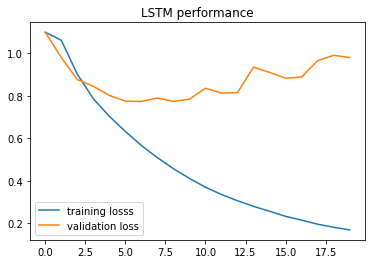

In [ ]:
# A clear case of overfitting
plt.plot([i for i in range(20)], losses, label = 'training losss')
plt.plot(val_losses, label = 'validation loss')
plt.title("LSTM performance")
plt.legend()
plt.show()

In [38]:
for i, j in test_ids:
  print(i, j)
  break

tensor([    1, 44012,  6480, 16607,   487,  2338,    23,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]) tensor(2)


In [90]:
def predict(model, dataloader, optimizer, lstm = None):
  predictions = []
  targets = []

  for batch_idx, batch in enumerate(dataloader):

    if lstm:
      h0, c0 =  model.init_hidden()
      h0 = h0.to(device)
      c0 = c0.to(device)

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
      if lstm:
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
      else: 
        out = model(input)
        _, preds = torch.max(F.softmax(out.squeeze(0), dim=-1), 1)
      preds = preds.to("cpu").tolist()
      targets_ = target.to("cpu").tolist()
      predictions.extend(preds)
      targets.extend(targets_)
  
  return predictions, targets

In [55]:
batch_acc = []

# lstm_model.load_state_dict(torch.load('/content/best_model.pt'))

lstm_model = LSTM_SentimentAnalysis(len(index2word), 64, 32, 0.2)
lstm_model.load_state_dict(torch.load("/content/best_model_LSTM.pt"))
lstm_model = lstm_model.to(device)

for batch_idx, batch in enumerate(test_dl):
  
  h0, c0 =  lstm_model.init_hidden()
  
  input = batch[0].to(device)
  target = batch[1].to(device)

  h0 = h0.to(device)
  c0 = c0.to(device)

  optimizer_lstm.zero_grad()
  with torch.set_grad_enabled(False):
      out, hidden = lstm_model(input, (h0, c0))
      _, preds = torch.max(out, 1)
      preds = preds.to("cpu").tolist()
      batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5866935483870968

# GRU

In [54]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = 0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout=dropout, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))        
        output, hidden = self.rnn(embedded)
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        hidden = self.dropout(hidden)
        out = self.fc(hidden)
        return out

In [55]:
INPUT_DIM =len(index2word)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 3
DROPOUT = 0.2

model_gru = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model_gru.load_state_dict(torch.load("/content/best_model_GRU.pt"))
model_gru = model_gru.to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [56]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [57]:
def train(model, dataloader, optimizer, criterion):
    
    epoch_loss = 0
    
    model.train()

    for inputs, targets in dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)
        
      optimizer.zero_grad()

      predictions = model(inputs).squeeze(0)

      loss = criterion(predictions, targets)
      
      loss.backward()
      
      optimizer.step()
      
      epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

In [58]:
def eval(model, dataloader, criterion):

  model.eval()
  total_val_loss = 0.0

  with torch.no_grad():

    for inputs, targets in dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)
      out = model(inputs).squeeze(0)
      loss = criterion(out, targets)

      total_val_loss += loss.item()
    
  return total_val_loss / len(dataloader)

In [ ]:
N_EPOCHS = 20
best_val_loss = np.Inf
train_gru_loss = []
train_val_loss = []

for epoch in range(N_EPOCHS):
    train_loss = train(model_gru, train_dl, optimizer, criterion)
    val_loss = eval(model_gru, valid_dl, criterion)

    train_gru_loss.append(train_loss)
    train_gru_loss.append(val_loss)

    if best_val_loss > val_loss:
      torch.save(model_gru.state_dict(), 'best_model_GRU.pt')
      print("Saved Model")
      best_val_loss = val_loss    
    
    print(f"After epoch {epoch} the train loss is: {train_loss}, validation loss is {val_loss}")

Saved Model
After epoch 0 the train loss is: 1.0987922246203967, validation loss is 1.098661751378307
Saved Model
After epoch 1 the train loss is: 1.0520582665267224, validation loss is 0.9714048356147102
Saved Model
After epoch 2 the train loss is: 0.9315366649933857, validation loss is 0.886809446452731
Saved Model
After epoch 3 the train loss is: 0.8590961271879983, validation loss is 0.8575963189588726
Saved Model
After epoch 4 the train loss is: 0.8101392734658979, validation loss is 0.8194094537206776
Saved Model
After epoch 5 the train loss is: 0.7714051706636686, validation loss is 0.792265375905274
After epoch 6 the train loss is: 0.7354880670459518, validation loss is 0.810277839671841
Saved Model
After epoch 7 the train loss is: 0.7040231471083435, validation loss is 0.7697643800170382
Saved Model
After epoch 8 the train loss is: 0.6749349877915225, validation loss is 0.7530664671191853
After epoch 9 the train loss is: 0.645867682055145, validation loss is 0.7540338220146808

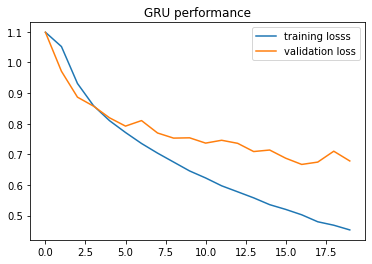

In [ ]:
plt.plot([i for i in range(20)], train_gru_loss[0::2], label = 'training losss')
plt.plot(train_gru_loss[1::2], label = 'validation loss')
plt.title("GRU performance")
plt.legend()
plt.show()

# Comparison (LSTM VS GRU)


In [114]:
preds_lstm, target_lstm = predict(lstm_model, test_dl, optimizer_lstm, True)
accuracy_score(preds_lstm, target_lstm)

0.5887096774193549

In [112]:
preds_GRU, target_GRU = predict(model_gru, test_dl, optimizer, False)
accuracy_score(preds_GRU, target_GRU)

0.6189516129032258

In [115]:
# LSTM comparison
print(classification_report(target_lstm, preds_lstm))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65       177
           1       0.41      0.66      0.51       137
           2       0.73      0.54      0.62       182

    accuracy                           0.59       496
   macro avg       0.62      0.59      0.59       496
weighted avg       0.64      0.59      0.60       496



In [117]:
print(classification_report(target_GRU, preds_GRU))

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       177
           1       0.44      0.76      0.56       138
           2       0.76      0.57      0.65       181

    accuracy                           0.62       496
   macro avg       0.67      0.63      0.62       496
weighted avg       0.69      0.62      0.63       496



GRU is simpler when compared to LSTM because of the absence of a seprate forget gate unlike LSTM. So, there are fewer parameters to learn in in GRU when compared to LSTM. Also, considering the small amount of data that we have in our case GRU is a good choice because of the faster computation and inexpensive resources. LSTMs perform in retaining the longer sequence of sentences.

In [118]:
test_dl = DataLoader(test_ids, shuffle=False, batch_size=batch_size, drop_last=True)

In [125]:
preds_GRU, target_GRU = predict(model_gru, test_dl, optimizer, False)

In [139]:
clean_test_df_copy = clean_test_df.loc[:495]

In [ ]:
clean_test_df_copy["predictions"] = preds_GRU

In [142]:
# C_tweet is the transformed tweet
clean_test_df_copy[:25]

,target,C_tweet,predictions
0,2,loooooooovvvvvveee kindle dx cool fantastic right,2
1,2,reading kindle love lee childs good read,2
2,2,ok first assesment kindle fucking rocks,1
3,2,love kindle mine months never looked back new ...,2
4,2,fair enough kindle think perfect,2
5,2,big quite happy kindle,2
6,0,fuck economy hate aig non loan given asses,0
7,2,jquery new best friend,2
8,2,loves twitter,1
9,2,love obama makes jokes,2
